In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.utils.plot_utils import *
from csbdeep.data.transform import Transform

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.models.sample_patches import sample_patches

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

np.random.seed(42)
lbl_cmap = random_label_cmap()

%reload_ext autoreload
%autoreload 2

print(tf.__version__)

Using TensorFlow backend.


1.13.2


In [2]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12127495537263504006
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9697300130232875003
physical_device_desc: "device: XLA_CPU device"
]


## Load sample data

In [4]:
%pwd

'/home/lis-paul/stardist/examples/2D'

In [5]:
X = sorted(glob('/home/lis-paul/data/dsb2018/dsb2018_sub1/images/*.tif'))
Y = sorted(glob('/home/lis-paul/data/dsb2018/dsb2018_sub1/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [6]:
X[0]

'/home/lis-paul/data/dsb2018/dsb2018_sub1/images/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1.tif'

In [7]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 292/292 [00:01<00:00, 238.65it/s]


In [8]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
# ind = rng.permutation(len(X))
ind = np.arange(0, len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

In [9]:
ind_train, ind_val

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [10]:
#manual assign train/val index for debugging
# ind_train = [1,2,3,4]
# ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 292
- training:       248
- validation:      44


(520, 696)

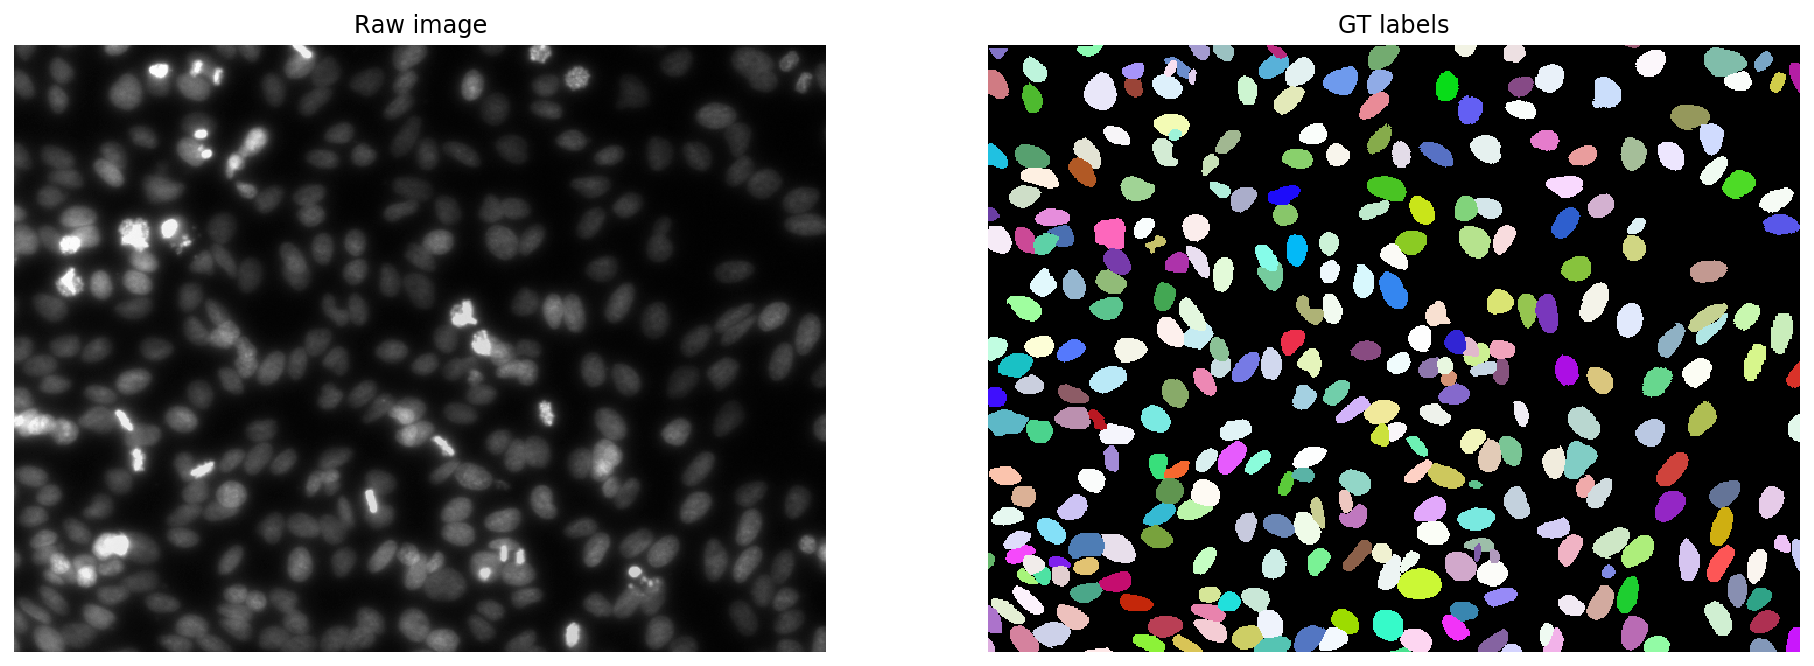

In [11]:
i = 8
# img, lbl = X[i], Y[i]
# img, lbl = X_val[i], Y_val[i]
img, lbl = X_trn[i], Y_trn[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;
img.shape

## Try with other augmentation packages and use stardist generator pipe (keras sequence) 

In [12]:
import cv2
from albumentations import *

In [13]:
AUGMENTATIONS_TRAIN = Compose([
#     Flip(p=1),
#     Rotate(limit=45, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, always_apply=False, p=0.5),
#     GaussNoise(var_limit=(0.0, 0.1), mean=0, always_apply=False, p=0.5)
#     GaussianBlur(blur_limit=21, p=1),
    GlassBlur(sigma=0.7, max_delta=4, iterations=2, always_apply=False, mode='fast', p=1)
#     ShiftScaleRotate(scale_limit=(0.2, 0.8), rotate_limit=45, interpolation=0, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
#     OneOf([
# #         IAAAdditiveGaussianNoise(p=0.5),
#         Downscale(scale_min = 0.5, scale_max=0.5, p=0.5),
#         ElasticTransform(p=0.5),
#     ])
#     RandomScale(scale_limit=0.5, interpolation=1, always_apply=True, p=0.9),
#     Downscale(scale_min = 0.5, scale_max=0.5, p=0.5),
#     ElasticTransform(alpha=1000, sigma=100, p=1)
], p=1)

### test the crop function on list

In [14]:
def crop_img(img, patch_size=256):
    xc=img.shape[0]//2
    yc=img.shape[1]//2
    hs = patch_size//2
    
    return img[xc-hs:xc+hs, yc-hs:yc+hs]

In [15]:
img.shape

(520, 696)

In [16]:
test = crop_img(img, 256) ; test.shape

(256, 256)

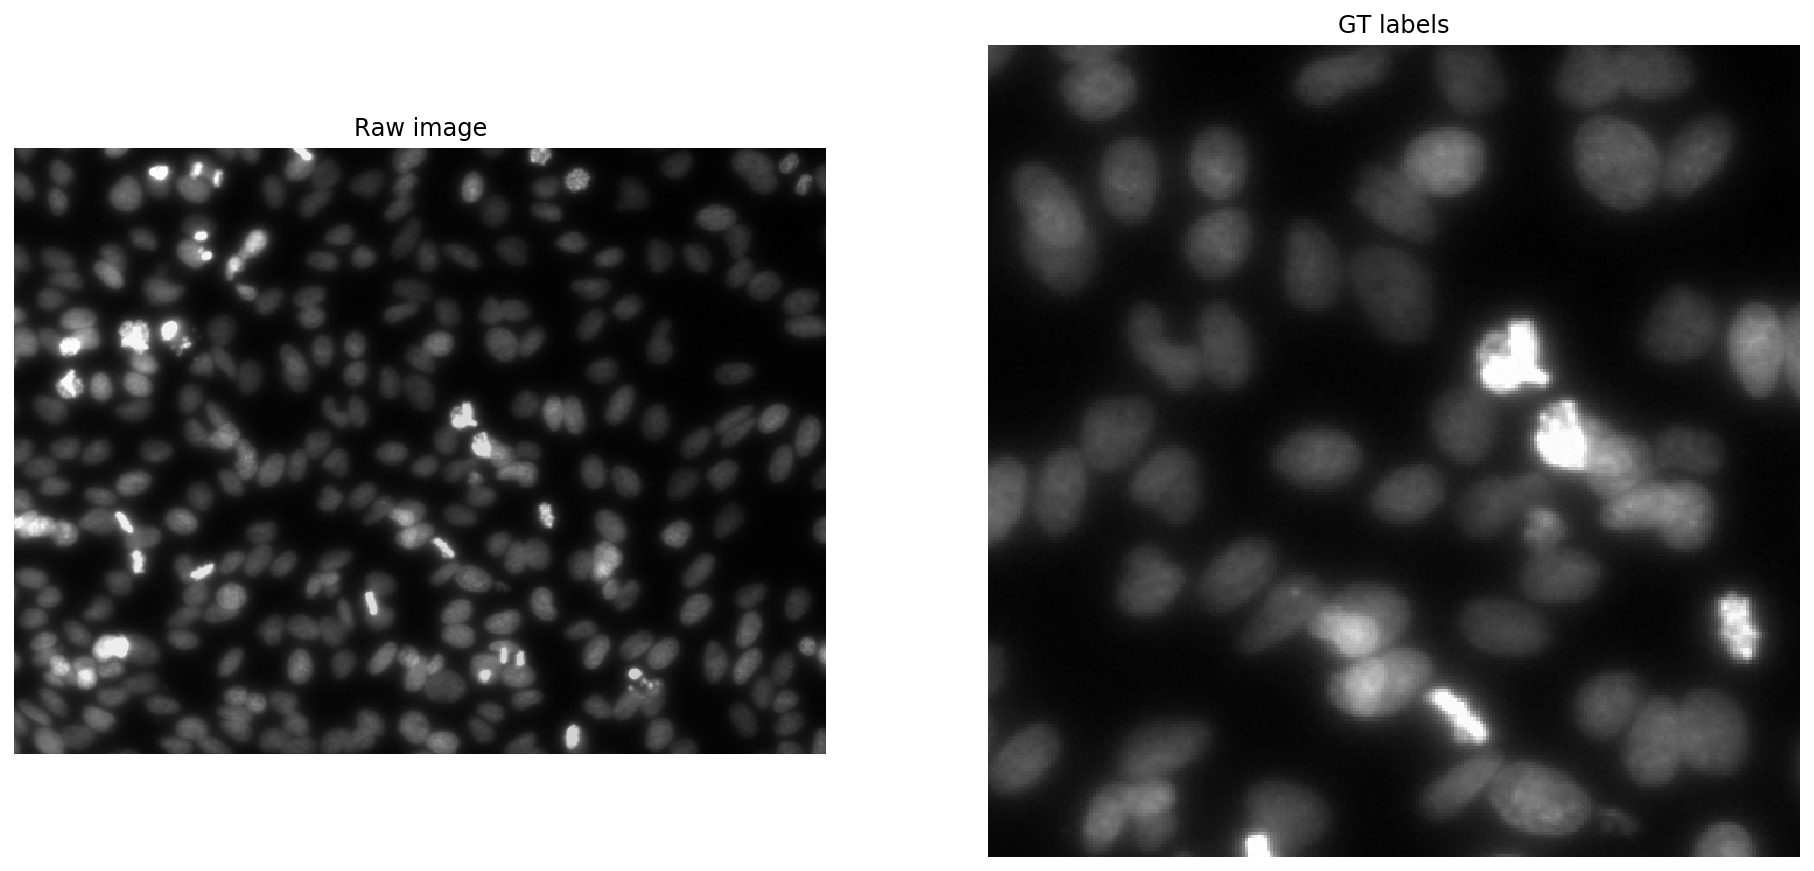

In [81]:
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(test,cmap='gray'); plt.axis('off'); plt.title('GT labels')
None;

In [97]:
XX = X_trn[:8]
YY = Y_trn[:8]
XX = list(map(crop_img, XX))
YY = list(map(crop_img, YY))

In [98]:
X_arr = np.stack(XX)
Y_arr = np.stack(YY)
X_arr.shape, Y_arr.shape

((8, 256, 256), (8, 256, 256))

### run augmentation of the test images

In [17]:
XX = X_trn[:8]
YY = Y_trn[:8]
XX = list(map(crop_img, XX))
YY = list(map(crop_img, YY))
X_arr = np.stack(XX)
Y_arr = np.stack(YY)
X_arr.shape, Y_arr.shape

((8, 256, 256), (8, 256, 256))

In [137]:
ranf=list(np.random.ranf(8)/5)

AUG_None = Compose([
    GaussNoise(var_limit=(0.0, 0.1), mean=0, always_apply=False, p=0)
                   ], p=1)
AUG_Test = Compose([
    Flip(p=0.5),
    ShiftScaleRotate(shift_limit=0, scale_limit=(0.0, 1.2), rotate_limit=10, 
                     interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0, always_apply=False, p=1),
    CoarseDropout(max_holes=64, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, 
                  fill_value=ranf, always_apply=False, p=1),
    GaussNoise(var_limit=(0.0, 0.15), mean=0, always_apply=False, p=0.5),
    GaussianBlur(blur_limit=33, p=0.5),
    ElasticTransform(alpha=100, sigma=7, alpha_affine=1, p=0.7, 
                     interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0),

], p=1)

(8, 256, 256)
(8, 256, 256)


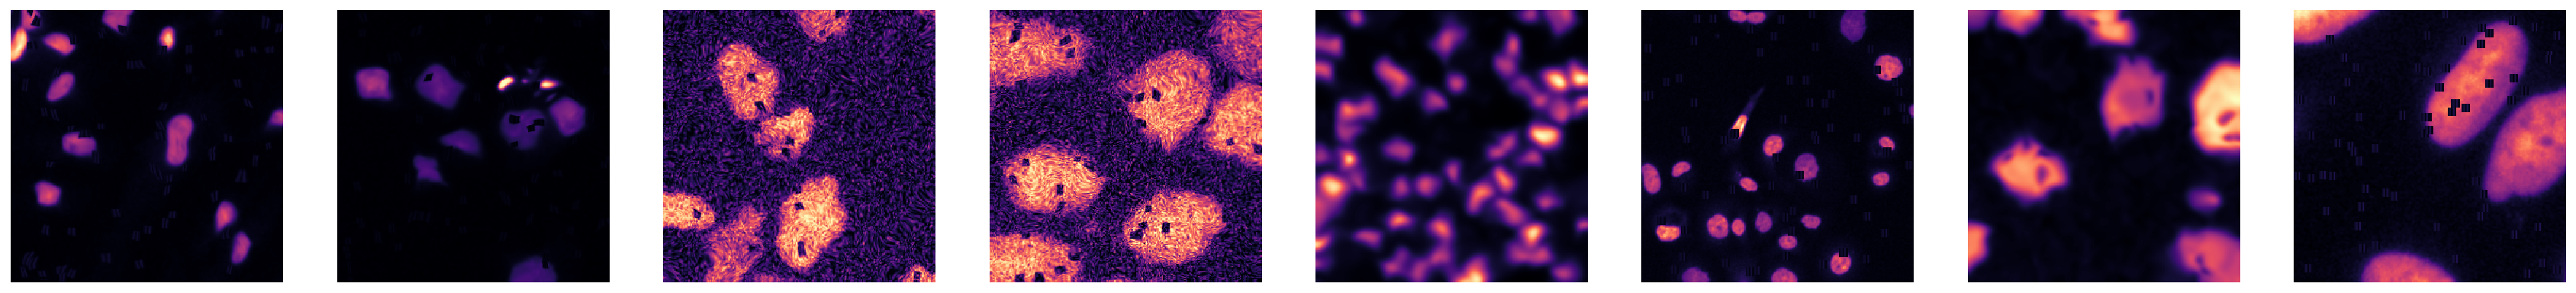

In [140]:
augmentation = AUG_Test
image, mask = zip(*[augmentation(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X_arr,Y_arr)]) ## output XX, YY are tuples so we can plug them back into the pipe
imageArr = np.array(image)
maskArr = np.array(mask)
imageArr.shape
print(imageArr.shape)
print(maskArr.shape)
plot_some(imageArr, x_inch=30, y_inch=20)

(8, 256, 256)
(8, 256, 256)


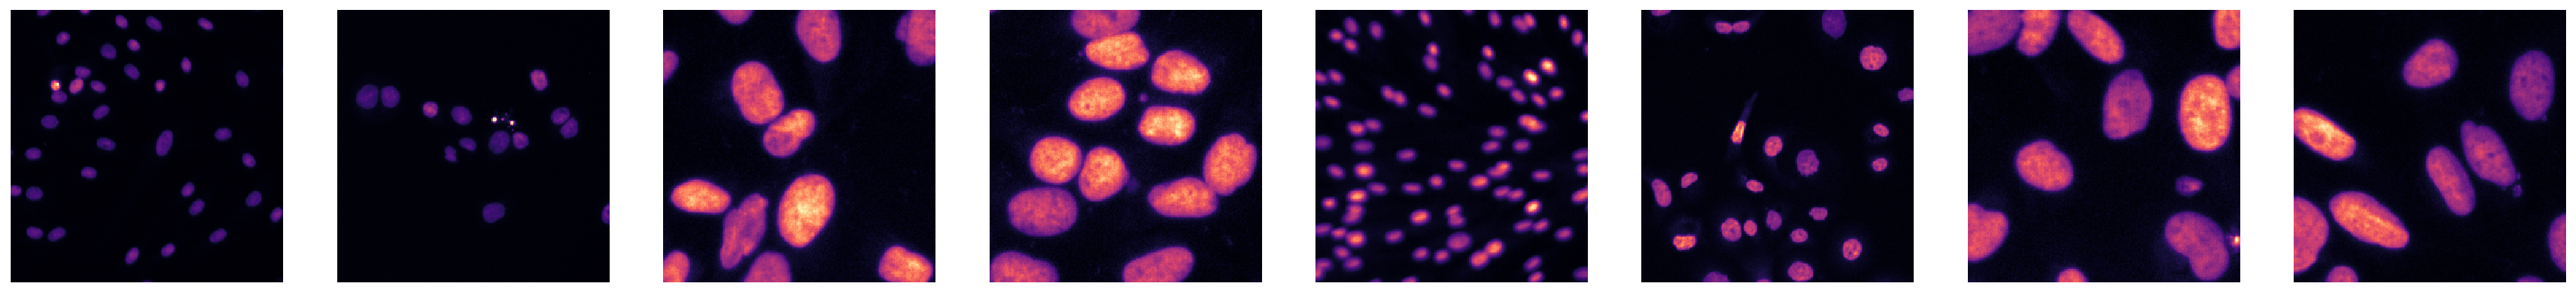

In [21]:
augmentation = AUG_None
image, mask = zip(*[augmentation(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X_arr,Y_arr)]) ## output XX, YY are tuples so we can plug them back into the pipe
# data = {"image": X_arr, "mask": Y_arr}
# augmented = augmentation(**data)
# image, mask = augmented["image"], augmented["mask"]
# image.shape, mask.shape
imageArr = np.array(image)
maskArr = np.array(mask)
print(imageArr.shape)
print(maskArr.shape)
plot_some(imageArr, x_inch=30, y_inch=20)

In [22]:
data_train = StarDistData2D(X_trn, Y_trn, batch_size=8, n_rays=32, patch_size=(256,256), augmenter=None, shape_completion=False)

In [138]:
%%debug
XX, YY = data_train[0]


NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(2)<module>()



ipdb>  s


--Call--
> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(49)__getitem__()
     47 
     48 
---> 49     def __getitem__(self, i):
     50         idx = slice(i*self.batch_size,(i+1)*self.batch_size) # here the idx progresses in step of batch_size as the i progresses
     51         idx = list(self.perm[idx]) # the self.perm is an array of index that will be shuffled at the end of epoch



ipdb>  s


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(50)__getitem__()
     48 
     49     def __getitem__(self, i):
---> 50         idx = slice(i*self.batch_size,(i+1)*self.batch_size) # here the idx progresses in step of batch_size as the i progresses
     51         idx = list(self.perm[idx]) # the self.perm is an array of index that will be shuffled at the end of epoch
     52 



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(51)__getitem__()
     49     def __getitem__(self, i):
     50         idx = slice(i*self.batch_size,(i+1)*self.batch_size) # here the idx progresses in step of batch_size as the i progresses
---> 51         idx = list(self.perm[idx]) # the self.perm is an array of index that will be shuffled at the end of epoch
     52 
     53         # the output from the sample_patches is also a list..... so basically we turn a list of list into a n-dim array



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(54)__getitem__()
     52 
     53         # the output from the sample_patches is also a list..... so basically we turn a list of list into a n-dim array
---> 54         arrays = np.hstack([sample_patches((self.Y[k],) + self.channels_as_tuple(self.X[k]),
     55                                  patch_size=self.patch_size, n_samples=1,
     56                                  valid_inds=self.get_valid_inds(k)) for k in idx])



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(56)__getitem__()
     54         arrays = np.hstack([sample_patches((self.Y[k],) + self.channels_as_tuple(self.X[k]),
     55                                  patch_size=self.patch_size, n_samples=1,
---> 56                                  valid_inds=self.get_valid_inds(k)) for k in idx])
     57 
     58 #         if self.n_channel is None:



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(62)__getitem__()
     60 #         else:
     61 #             X, Y = list(zip(*[(np.stack([_x[0] for _x in x],axis=-1)[self.b], y[0]) for y,*x in arrays]))
---> 62         X = arrays[1,...,self.bb,self.bb]   #the elipsis at second dimension is reserved for channels>1, but not tested
     63         Y = arrays[0,...,self.bb,self.bb].astype('uint16')
     64 



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(63)__getitem__()
     61 #             X, Y = list(zip(*[(np.stack([_x[0] for _x in x],axis=-1)[self.b], y[0]) for y,*x in arrays]))
     62         X = arrays[1,...,self.bb,self.bb]   #the elipsis at second dimension is reserved for channels>1, but not tested
---> 63         Y = arrays[0,...,self.bb,self.bb].astype('uint16')
     64 
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)__getitem__()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  X.shape


(8, 256, 256)


ipdb>  s


--Call--
> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)<listcomp>()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  s


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)<listcomp>()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  s


--Call--
> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(103)<lambda>()
    101         if augmenter is None:
    102 #             augmenter = lambda *args: args
--> 103             augmenter = lambda **kwargs: kwargs
    104         callable(augmenter) or _raise(ValueError("augmenter must be None or callable"))
    105         self.augmenter = augmenter



ipdb>  u


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)<listcomp>()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  _x.shape


(256, 256)


ipdb>  s


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(103)<lambda>()
    101         if augmenter is None:
    102 #             augmenter = lambda *args: args
--> 103             augmenter = lambda **kwargs: kwargs
    104         callable(augmenter) or _raise(ValueError("augmenter must be None or callable"))
    105         self.augmenter = augmenter



ipdb>  u


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)<listcomp>()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)<listcomp>()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)<listcomp>()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)<listcomp>()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)<listcomp>()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)<listcomp>()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)<listcomp>()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)<listcomp>()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)<listcomp>()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  n


--Return--
[dict_values([...type=uint16)]), dict_values([...type=uint16)]), dict_values([...type=uint16)]), dict_values([...type=uint16)]), dict_values([...type=uint16)]), dict_values([...type=uint16)]), ...]
> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(67)<listcomp>()
     65 #         X, Y = tuple(zip(*tuple(self.augmenter(_x, _y) for _x, _y in zip(X,Y))))
     66         # The albumatation package took dict with image, mask as key as input
---> 67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
     69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)



ipdb>  n


> /home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/model2d.py(69)__getitem__()
     67         X, Y = zip(*[self.augmenter(**{"image":_x,"mask": _y}).values() for _x, _y in zip(X,Y)]) ## output XX, YY are tuples so we can plug them back into the pipe
     68 
---> 69         prob = np.stack([edt_prob(lbl[self.bb]) for lbl in Y])  ##Y is tuple but lbl is array, so need to slice with slice(self.bb) instead of tuple(self.b)
     70 
     71         if self.shape_completion:



ipdb>  X.shape


*** AttributeError: 'tuple' object has no attribute 'shape'


ipdb>  len(X)


8


ipdb>  X[0].shape


(256, 256)


ipdb>  (np.array(X)).shape


(8, 256, 256)


ipdb>  c


In [ ]:
i = np.random.randint(0,len(data_train))
XX, YY = data_train[i]

X,dist_mask = XX
prob,dist = YY

plot_some(X, dist_mask, prob, dist, x_inch=30, y_inch=20)

## Train with augmentations

In [11]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = False,
    n_channel_in = n_channel,
    train_batch_size = 8, 
    train_epochs = 400,
    train_steps_per_epoch = 200,
    train_one_cycle_lr_max = None,
    y_range = None,
    train_reduce_lr={'factor': 0.5, 'patience': 50, 'min_delta': 0},
    train_loss_weights=(1, 0.1)
#     train_background_reg=0.0005,  #instead of 0.0001
#     train_learning_rate=0.008
#     net_input_shape = (X_trn[0].shape[0], X_trn[0].shape[1], n_channel)
)

conf

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), norm_by_mask=True, train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.1), train_n_val_patches=None, train_one_cycle_lr_max=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 50, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=200, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False, y_rang

In [12]:
model = StarDist2D(conf, name='stardist', basedir='F_Rconstant_N_b8_masknorm_lossw0.1_csbsub1')

/home/lis-paul/miniconda3/envs/stardist/lib/python3.7/site-packages/csbdeep/models/base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: /home/lis-paul/stardist/examples/2D/F_Rconstant_N_b8_masknorm_lossw0.1_csbsub1/stardist
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [13]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=AUGMENTATIONS_TRAIN, multi=True, ncpu=8)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Epoch 1/400
200/200 [==============================] - 33s 164ms/step - loss: 1.1446 - prob_loss: 0.1982 - dist_loss: 9.4643 - prob_kld: 0.1261 - dist_relevant_mae: 9.4635 - dist_relevant_mse: 177.2892 - val_loss: 0.8561 - val_prob_loss: 0.1385 - val_dist_loss: 7.1765 - val_prob_kld: 0.0540 - val_dist_relevant_mae: 7.1756 - val_dist_relevant_mse: 97.6012
Epoch 2/400
200/200 [==============================] - 29s 147ms/step - loss: 0.5664 - prob_loss: 0.0947 - dist_loss: 4.7173 - prob_kld: 0.0229 - dist_relevant_mae: 4.7168 - dist_relevant_mse: 53.3961 - val_loss: 0.5031 - val_prob_loss: 0.0988 - val_dist_loss: 4.0426 - val_prob_kld: 0.0144 - val_dist_relevant_mae: 4.0421 - val_dist_relevant_mse: 42.6471
Epoch 3/400
200/200 [==============================

Probably due to custom activation function (lambda function), not be able to save model

In [23]:
# model.keras_model.save('1b_100s_400e.h5') 

# model.keras_model.load_weights('1b_100s_400e.h5')

# model.keras_model.summary()

## Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [14]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:11<00:02,  1.45it/s, 0.488 -> 0.894]


Using optimized values: prob_thresh=0.486828, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.48682814836502075, 'nms': 0.3}

In [33]:
%pwd

'/home/lis-paul/stardist/examples/2D'

In [34]:
model.export_TF(fname='2020-03-26-12-15_masknorm_noise')

## Prediction on Test set

In [15]:
X = sorted(glob('/home/lis-paul/data/centuri/test/images/*.tif'))
X = list(map(imread,X))
X[0].shape

(1022, 1022)

In [16]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

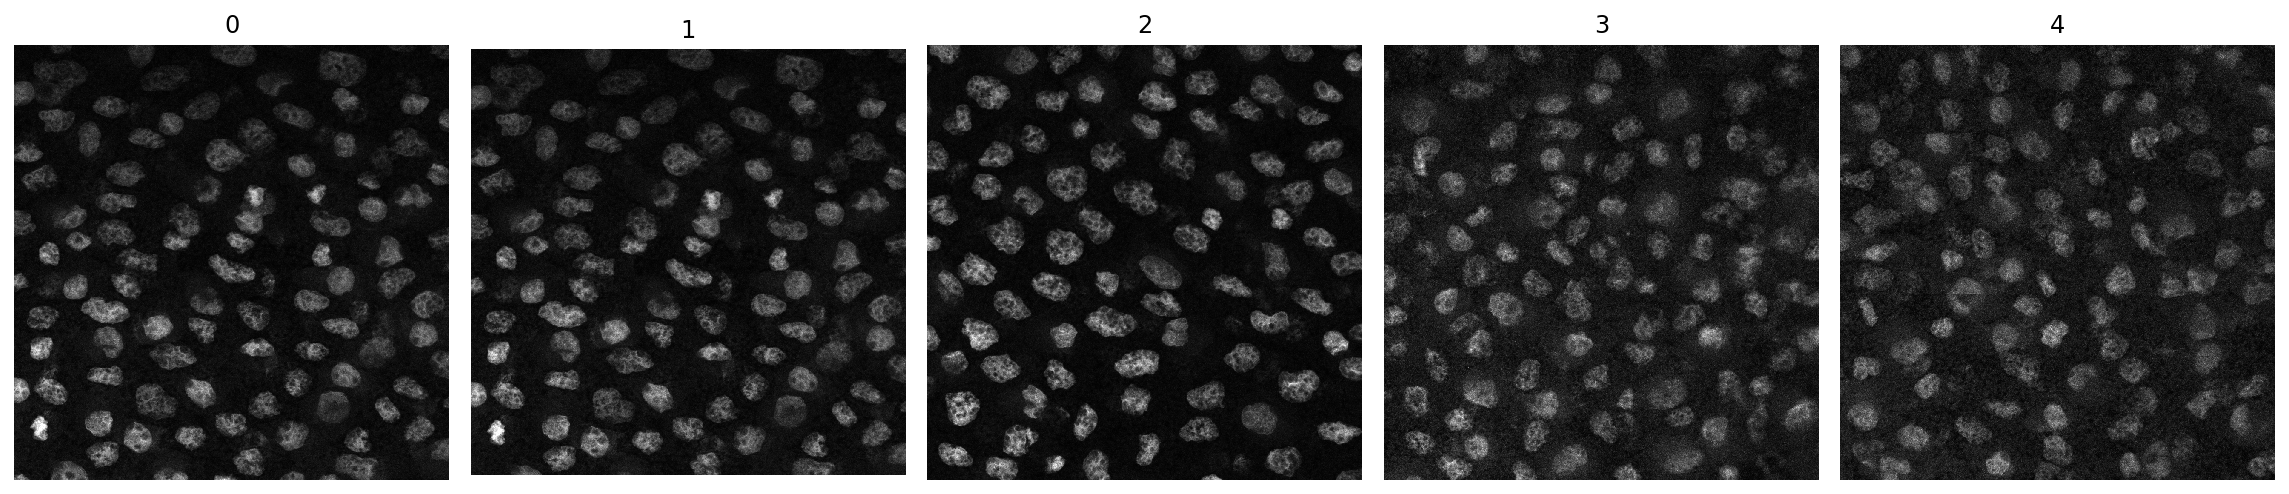

In [17]:
# show all test images
if True:
    fig, ax = plt.subplots(1,5, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [18]:
# demo_model = False

# if demo_model:
#     print (
#         "NOTE: This is loading a previously trained demo model!\n"
#         "      Please set the variable 'demo_model = False' to load your own trained model.",
#         file=sys.stderr, flush=True
#     )
#     model = StarDist2D(None, name='2D_demo', basedir='../../models/examples')
# else:
#     model = StarDist2D(None, name='stardist_tune', basedir='tune5_c0_csbsub')
# None;

(1022, 1022)


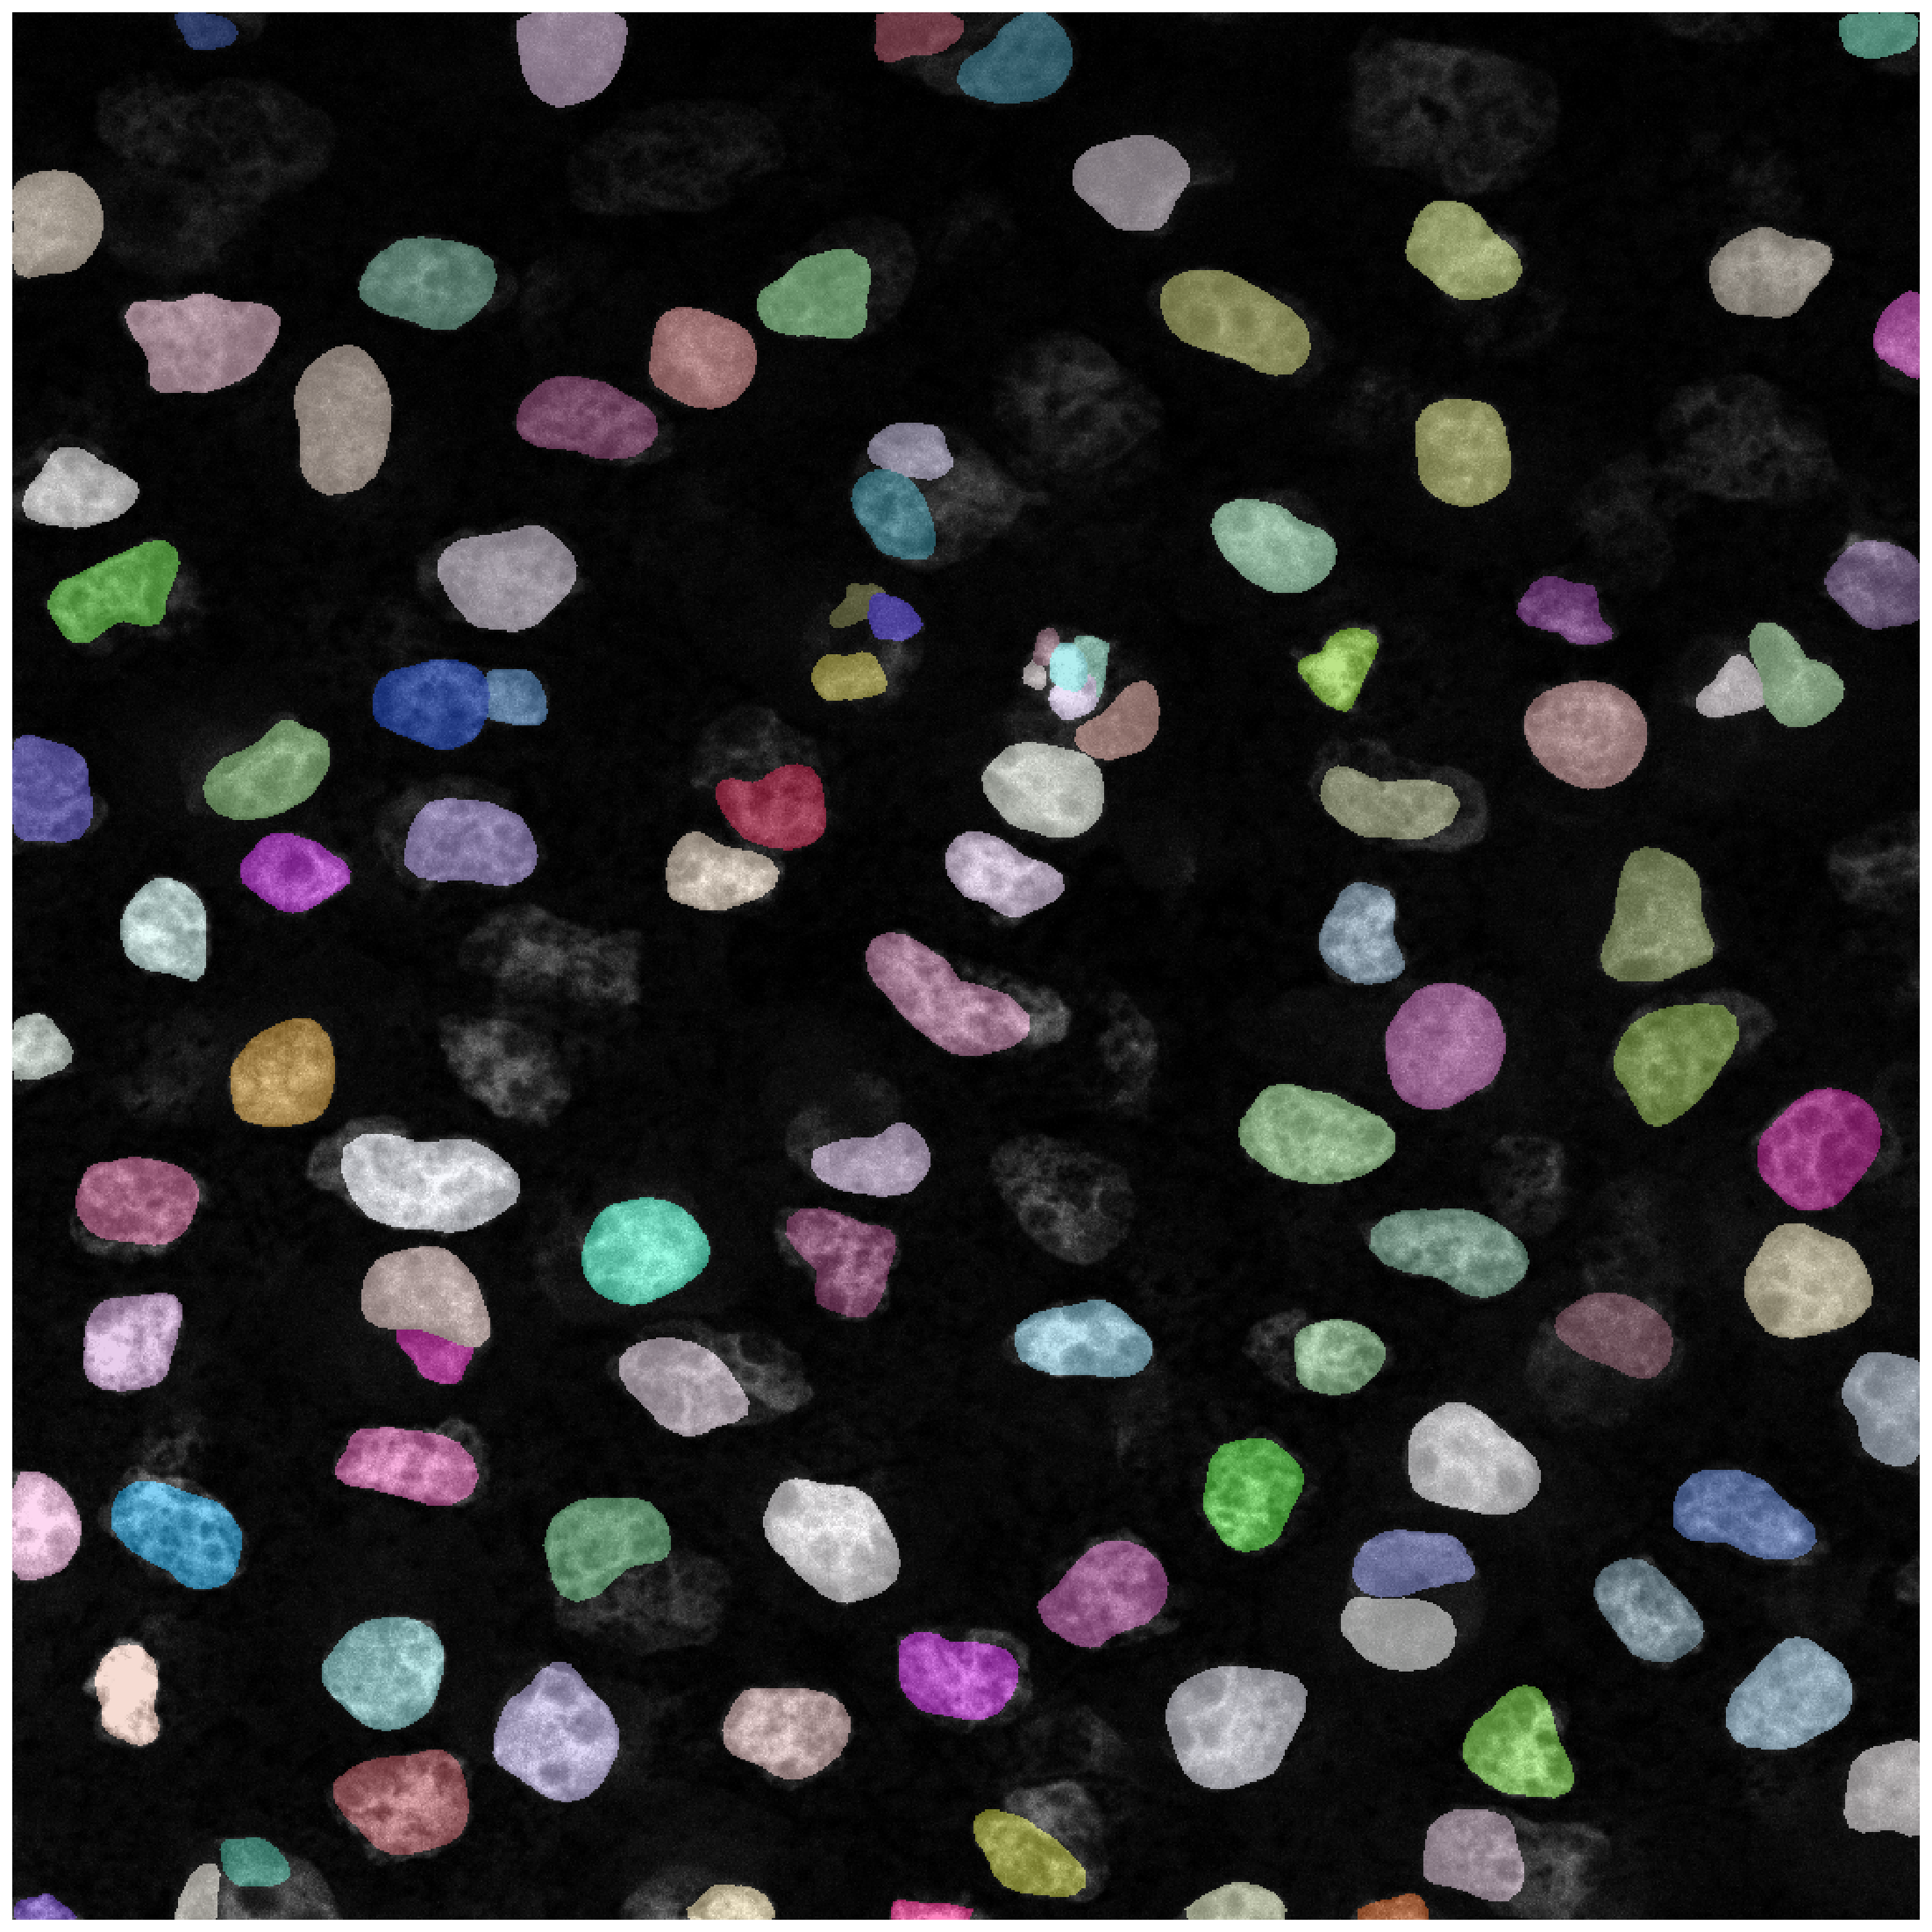

In [19]:
img = normalize(X[0], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img, prob_thresh=0.5, nms_thresh=0.3)
print(img.shape)
plt.figure(figsize=(20,20))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

(360, 360)


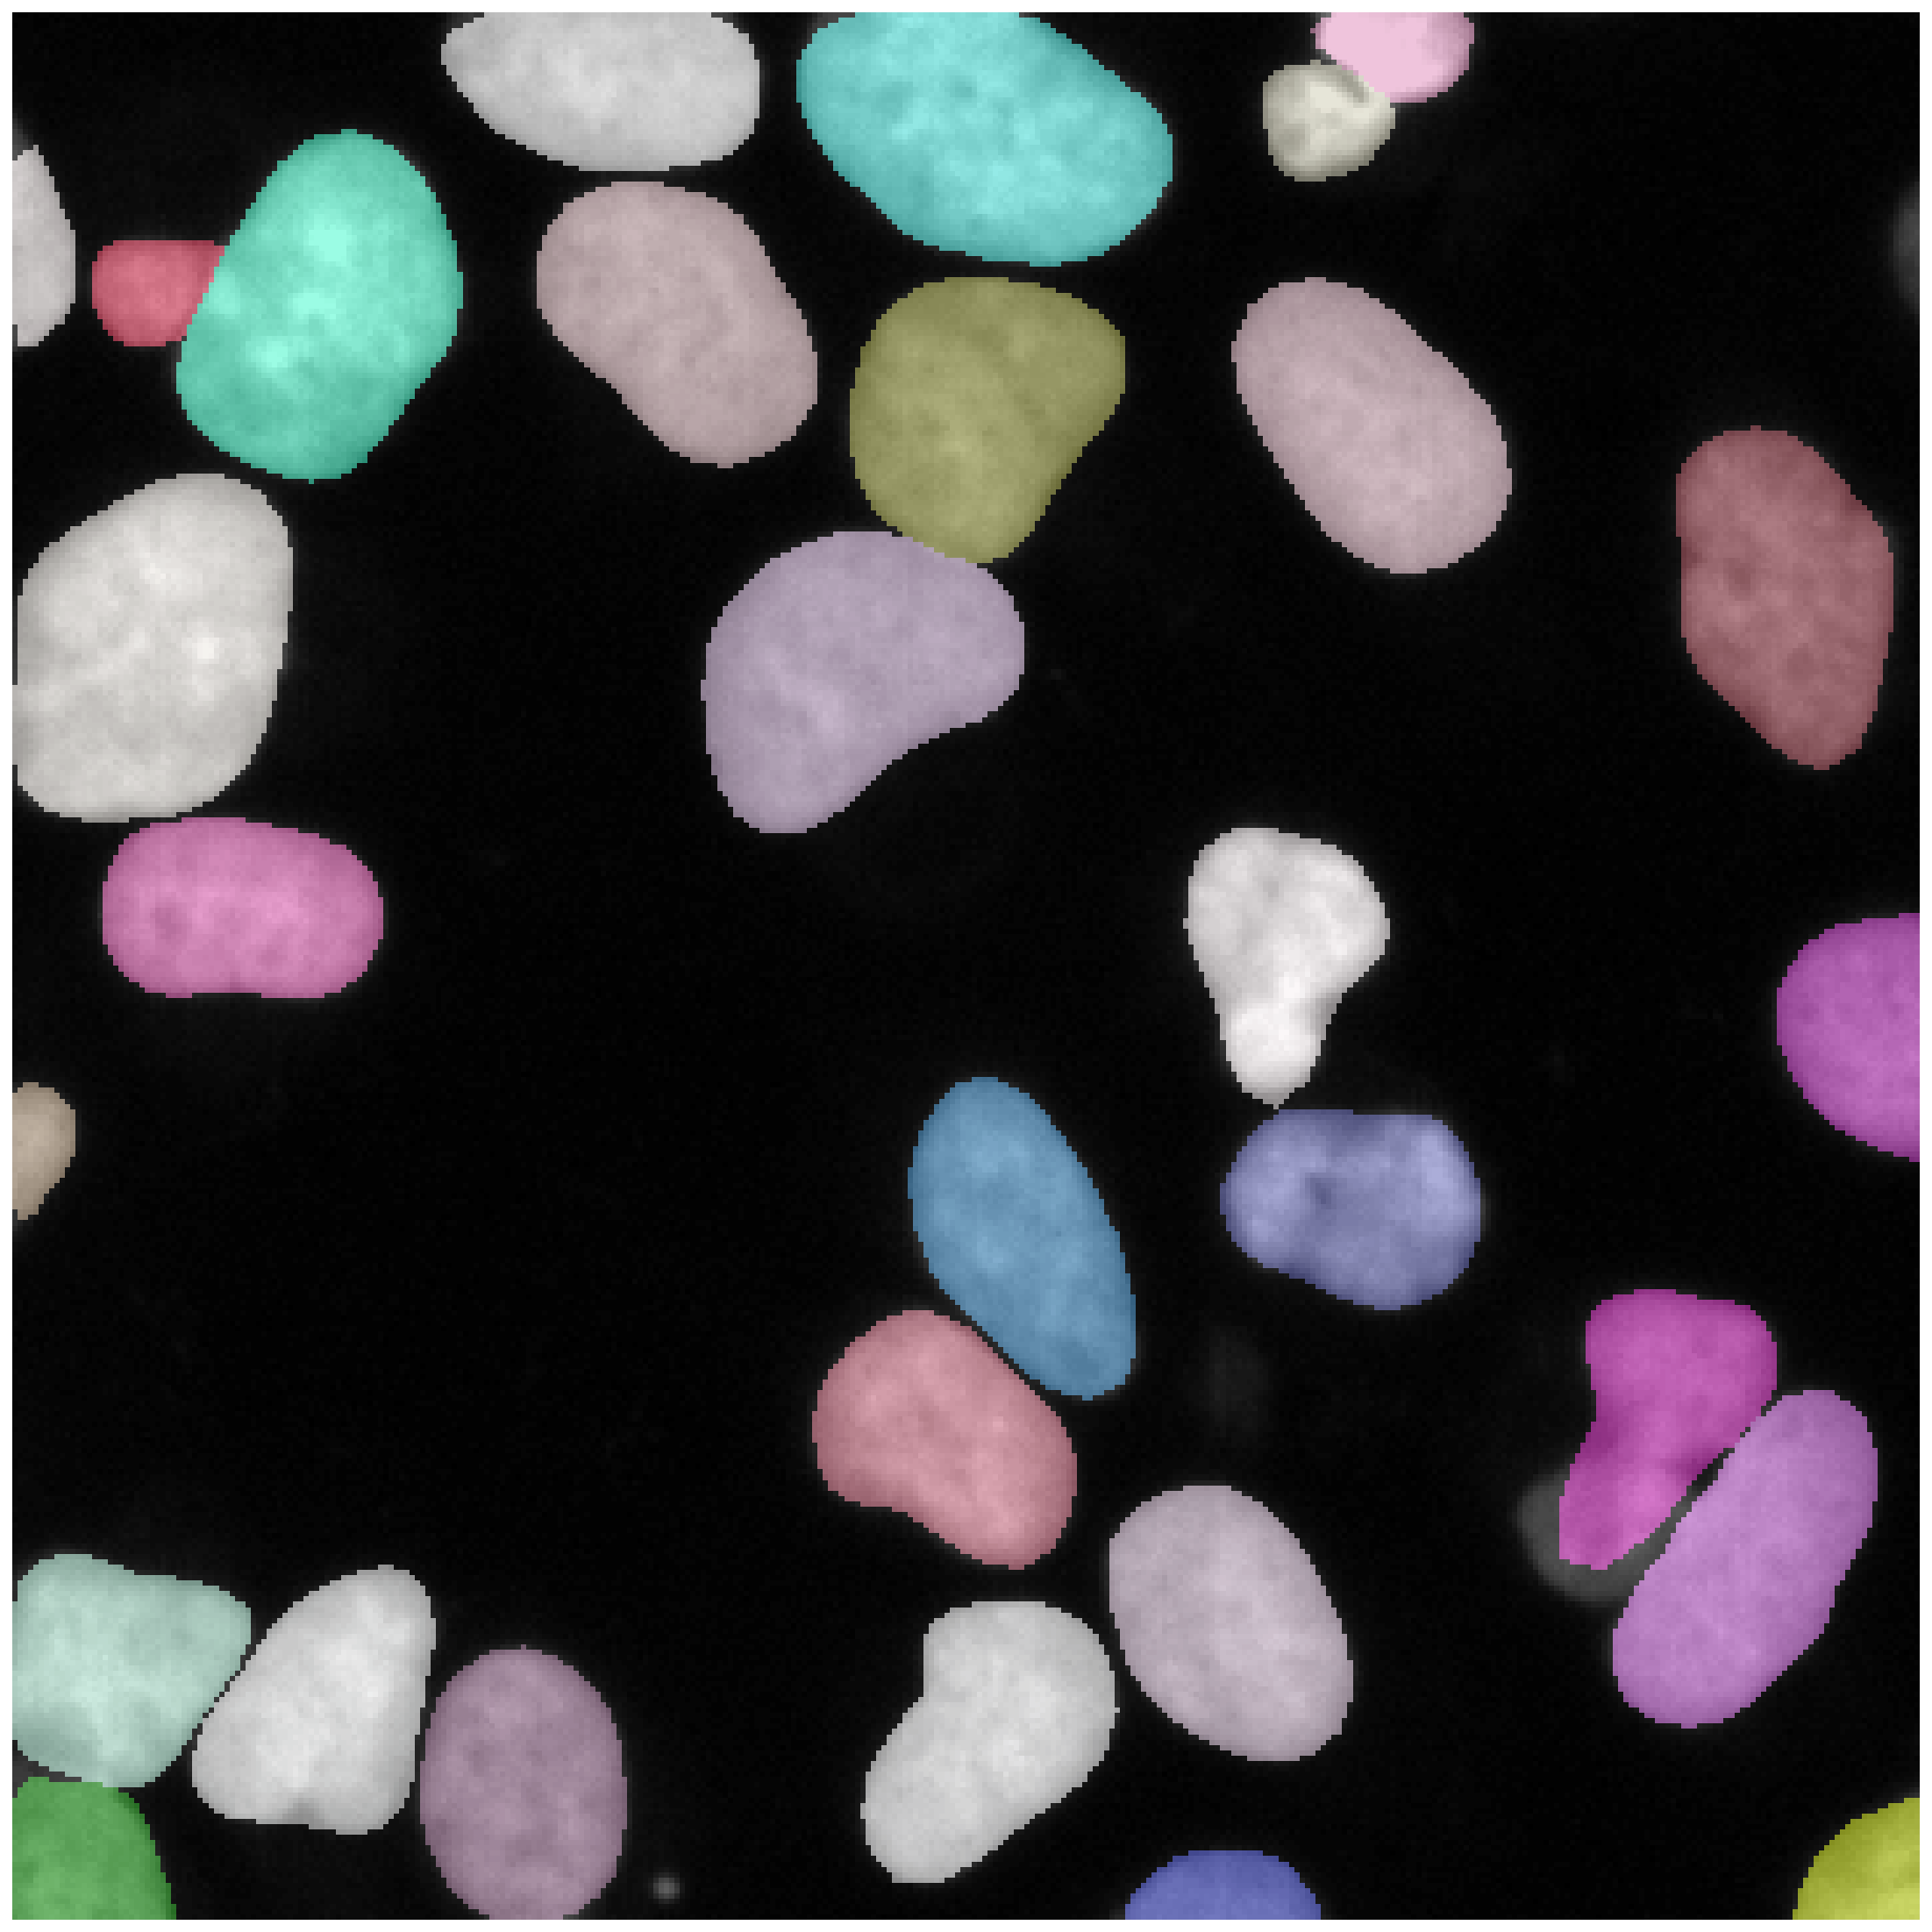

In [20]:
img = normalize(X_val[1], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

print(img.shape)
plt.figure(figsize=(20,20))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

# Example results

In [25]:
from stardist import random_label_cmap, _draw_polygons

def example(model, i, show_dist=True):
    img = normalize(X_val[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, grid=model.config.grid, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

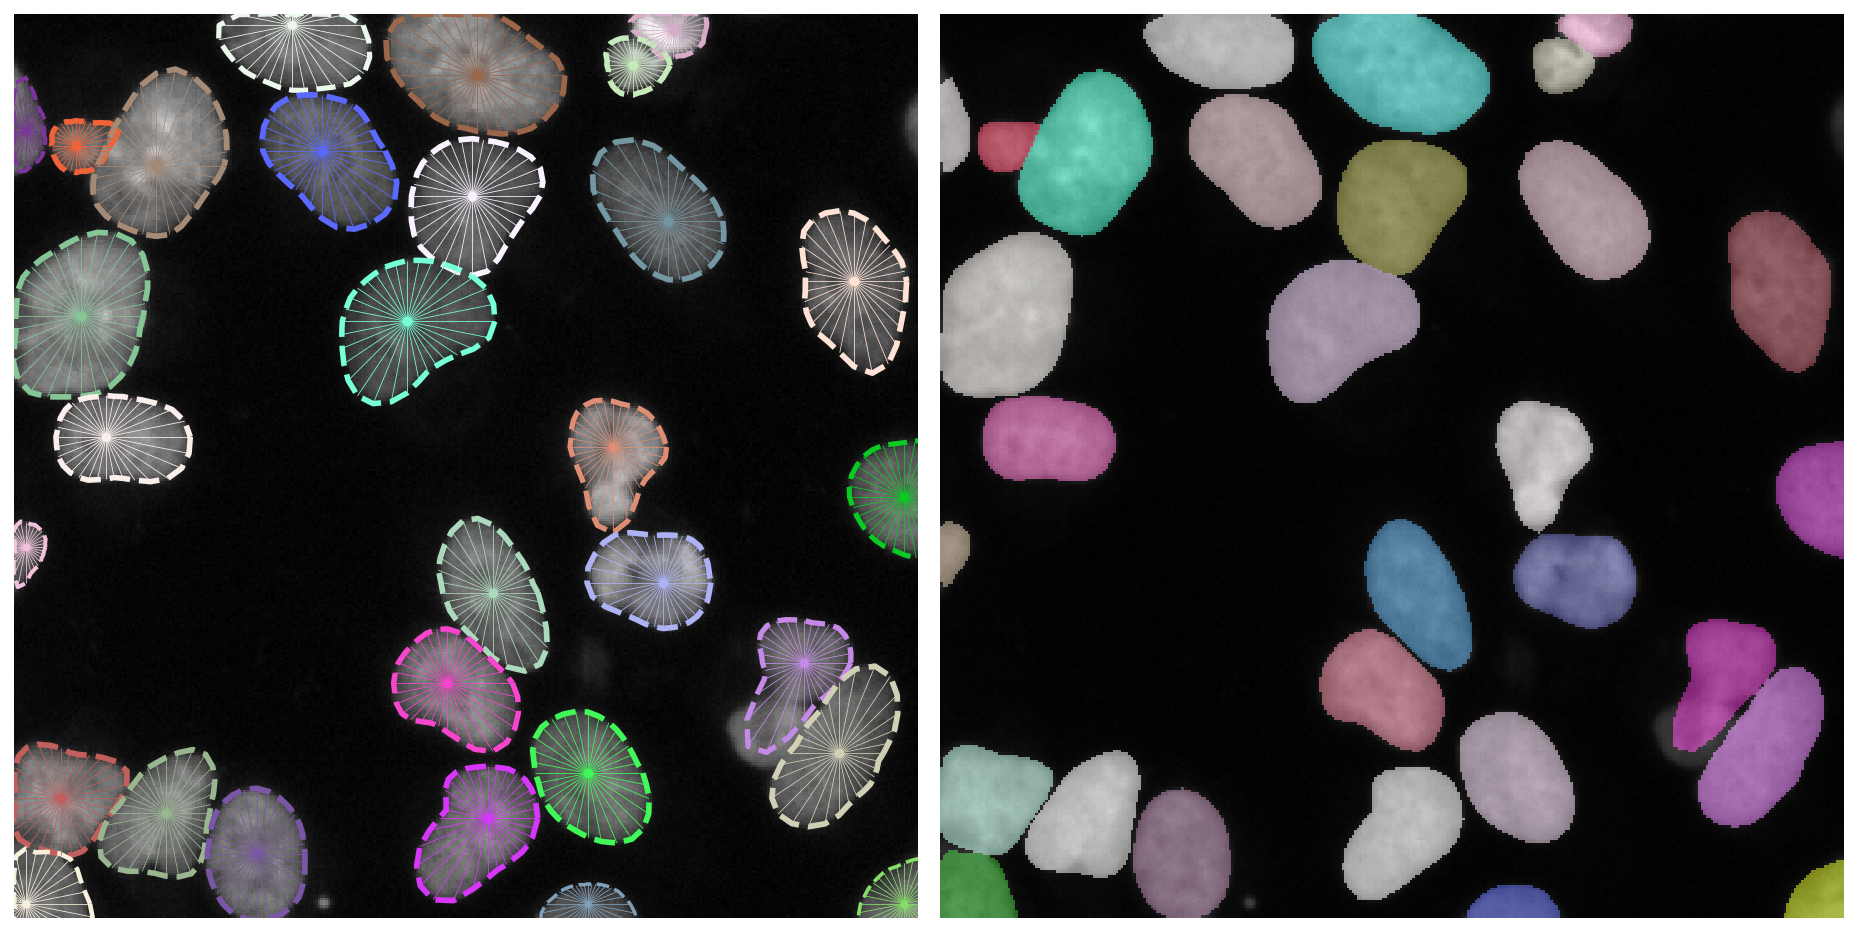

In [27]:
example(model, 1)